In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns

import itertools

from Battery import Battery
from DPModel import DPModel
from Logic import logic_no_bat, logic_bat, logic_DP
from Funcs_Logic_DP import logic_rollout, get_price, print_price_summary, logic_series_print, policy_rollout, DP_stochastic

In [2]:
def loadSeries(datatype=None,house=None,rename=None, shifts=None):
    '''
    Loading data series from cf_filled (consumption) or pf_filled (production)
    
    datatype: str, specifies whether the production or consumption values are selected
              
              "Production", "Consumption", "P", "C", "prod", "cons", etc.
    
    
    house: str, specifies which house is selected 
           
           "k28", "h16", "h22", "h28", or "h32"
         
    rename: str, renames chosen column. 
            
            If the whole file is returned, this parameter is ignored
            
    shifts: list of int, if given, specifies what shifted columns to add
    '''
    res = None
    #Production or consumption string stuff
    datatypeStr = ""
    if datatype is None:
        raise Exception("First input must specify either Production or Consumption")
    elif datatype[0].lower()=="p":
        datatypeStr = "prod_"
    elif datatype[0].lower()=="c":
        datatypeStr = "cons_"
    
    #Making sure an existing house is chosen
    if house is None:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    elif house.lower() not in ["k28","h16","h22","h28","h32"]:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    
    #Production or consumption is chosen and loaded
    if datatypeStr=="prod_":
        res = pd.read_csv("pf_filled.csv",sep=",")
        res = res[["Time",datatypeStr+house]]
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    else:
        res = pd.read_csv("cf_filled.csv",sep=",")
        res = res[["Time",datatypeStr+house]]
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    
    #Renaming value column
    if not house is None and not rename is None:
        res = res.rename(columns={datatypeStr+house: rename}, errors="raise")
    
    #Shifted columns added
    if not shifts is None:
        if rename is None:
            shiftname = 't'
        else:
            shiftname = rename
        dataframe = pd.DataFrame()
        for i in shifts:
            dataframe[shiftname + '-' + str(i)] = res.shift(i)
        res = pd.concat([res, dataframe], axis=1)
        res.dropna(inplace=True)
    
    #Nice stuff for indexing
    res['Year']=res.index.year
    res['Month']=res.index.month
    res['Day']=res.index.day
    res['Weekday']=res.index.weekday
    res['Hour']=res.index.hour
    return res

def moving_average(timeseries, window):
    return timeseries.rolling(window=window, center=True).mean()

In [3]:
pf_filled = pd.read_csv('pf_filled.csv')
cf_filled = pd.read_csv('cf_filled.csv')
df = pf_filled.merge(cf_filled)
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time',inplace=True)
df

,prod_k28,prod_h16,prod_h22,prod_h28,prod_h32,cons_k28,cons_h16,cons_h22,cons_h28,cons_h32
Time,,,,,,,,,,
2020-12-22 00:00:00,0.0,0.0,0.0,0.0,0.0,5.0,6.3,6.3,4.9,6.6
2020-12-22 01:00:00,0.0,0.0,0.0,0.0,0.0,4.3,4.8,6.5,4.4,5.4
2020-12-22 02:00:00,0.0,0.0,0.1,0.1,0.0,4.0,4.8,4.3,3.9,4.4
2020-12-22 03:00:00,0.0,0.0,0.0,0.0,0.0,3.8,4.3,3.3,3.2,3.7
2020-12-22 04:00:00,0.0,0.0,0.0,0.0,0.0,3.1,4.0,3.1,3.1,3.4
...,...,...,...,...,...,...,...,...,...,...
2023-01-10 16:00:00,0.3,0.3,0.3,0.2,0.0,10.9,6.1,6.2,6.3,5.9
2023-01-10 17:00:00,0.0,0.0,0.0,0.0,0.0,6.1,8.3,8.4,6.8,9.6
2023-01-10 18:00:00,0.0,0.0,0.0,0.0,0.0,9.7,10.4,17.1,8.8,13.5


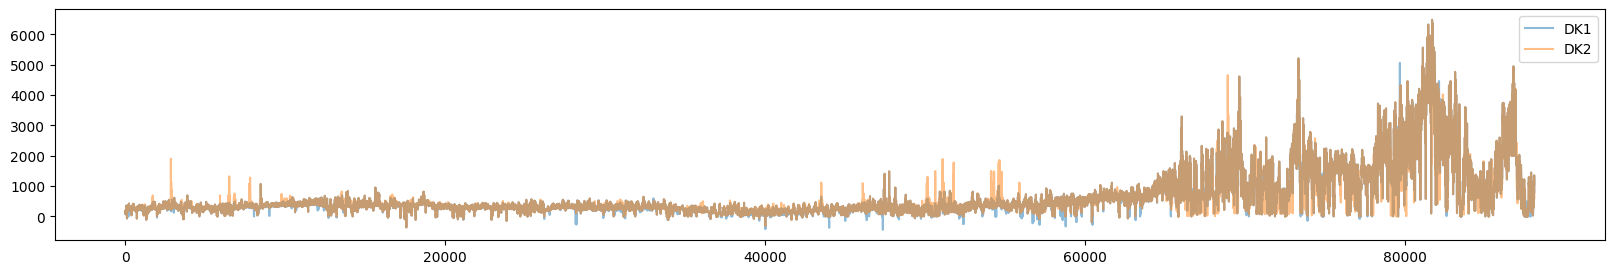

,prod_k28,prod_h16,prod_h22,prod_h28,prod_h32,cons_k28,cons_h16,cons_h22,cons_h28,cons_h32
Time,,,,,,,,,,
2020-12-22 00:00:00,0.0,0.0,0.0,0.0,0.0,5.0,6.3,6.3,4.9,6.6
2020-12-22 01:00:00,0.0,0.0,0.0,0.0,0.0,4.3,4.8,6.5,4.4,5.4
2020-12-22 02:00:00,0.0,0.0,0.1,0.1,0.0,4.0,4.8,4.3,3.9,4.4
2020-12-22 03:00:00,0.0,0.0,0.0,0.0,0.0,3.8,4.3,3.3,3.2,3.7
2020-12-22 04:00:00,0.0,0.0,0.0,0.0,0.0,3.1,4.0,3.1,3.1,3.4
...,...,...,...,...,...,...,...,...,...,...
2023-01-10 16:00:00,0.3,0.3,0.3,0.2,0.0,10.9,6.1,6.2,6.3,5.9
2023-01-10 17:00:00,0.0,0.0,0.0,0.0,0.0,6.1,8.3,8.4,6.8,9.6
2023-01-10 18:00:00,0.0,0.0,0.0,0.0,0.0,9.7,10.4,17.1,8.8,13.5


In [4]:
el = pd.read_csv('Elspotprices.csv', sep=';', decimal=',')
el = el.drop(['HourUTC','SpotPriceEUR'],axis=1)
el['HourDK'] = pd.to_datetime(el['HourDK'])

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(el[el['PriceArea']=='DK1']['SpotPriceDKK'],label='DK1',alpha=0.5)
plt.plot(el[el['PriceArea']=='DK2']['SpotPriceDKK'],label='DK2',alpha=0.5)
plt.legend()
plt.show()

el_dk1 = el[el['PriceArea']=='DK1']
el_dk2 = el[el['PriceArea']=='DK2']

timestamps = pd.DataFrame()
timestamps['HourDK'] = pd.date_range(el['HourDK'].min(), el['HourDK'].max(),freq='H')

el_dk1=el_dk1.merge(timestamps,on='HourDK',how='right')
el_dk2=el_dk2.merge(timestamps,on='HourDK',how='right')

el_dk1 = el_dk1.ffill() ### Sønderborg is in dk1
el_dk2 = el_dk2.ffill()

el_dk1 = el_dk1.set_index('HourDK')
el_dk1 = el_dk1.drop(['PriceArea'],axis=1)

el_dk1 = el_dk1.iloc[3*365*24+3-9*24:]


pf_filled = pd.read_csv('pf_filled.csv')
cf_filled = pd.read_csv('cf_filled.csv')
df = pf_filled.merge(cf_filled)
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time',inplace=True)
df

In [5]:
def merge(house=None,names=["prod","cons"]):
    if house is None:
        raise Exception("First input must specify house: k28, h16, h22, h28, or h32")
    elif house.lower() not in ["k28","h16","h22","h28","h32"]:
        raise Exception("First input must specify house: k28, h16, h22, h28, or h32")
    
    if names is None or len(names)!=2:
        raise Exception("Second input must be a string list of len 2: names=['prod','cons']")
    production = df[names[0]+"_"+house]
    consumption = df[names[1]+"_"+house]
    merged = pd.merge(production, consumption, how="outer", left_index=True,right_index=True)
    merged["power_yield"] = merged[names[0]+"_"+house] - merged[names[1]+"_"+house]
    merged = pd.merge(merged, el_dk1, how="outer", left_index=True,right_index=True)
    merged = merged[:-24] #missing last day because no spot prices for the last day
    return merged

In [6]:
house = "h16"
merged = merge(house)
merged

,prod_h16,cons_h16,power_yield,SpotPriceDKK
2020-12-22 00:00:00,0.0,6.3,-6.3,11.090000
2020-12-22 01:00:00,0.0,4.8,-4.8,-0.150000
2020-12-22 02:00:00,0.0,4.8,-4.8,-55.880001
2020-12-22 03:00:00,0.0,4.3,-4.3,-72.919998
2020-12-22 04:00:00,0.0,4.0,-4.0,-53.720001
...,...,...,...,...
2023-01-09 16:00:00,0.1,7.6,-7.5,1204.510010
2023-01-09 17:00:00,0.0,10.0,-10.0,1296.579956
2023-01-09 18:00:00,0.0,9.1,-9.1,1354.890015
2023-01-09 19:00:00,0.0,11.1,-11.1,1266.089966


## Running the logic models and DP

In [7]:
#"Input" variables
avg_yearly_cost_dict = {}
N = 12
bat_capacity=13
Start="2021-06-19 00:00:00"
End = pd.date_range(start=Start, periods=N, freq="h")[-1]

In [8]:
# Define battery with capcacity 0, same as no battery
battery_no_bat = Battery(max_capacity=0,max_charge=0)

series_no_battery = logic_rollout(merged.loc[Start:End].copy(), battery_no_bat, logic_no_bat, get_price)

charge_list_no_bat = battery_no_bat.charge_list

avg_yearly_cost_dict["No battery"] = (print_price_summary(series_no_battery), 
                                      np.sum(charge_list_no_bat[charge_list_no_bat>0]), 
                                      np.sum(charge_list_no_bat[charge_list_no_bat<=0]))

Cost for period: 2021-06-19 00:00:00 to 2021-06-19 11:00:00 is:  17.0  DKK
Average cost per year is: 13670.0 DKK
Number of kwh purchased in the period: 33.70000000001164
Average number of kwh purchased per year: 26855.83636364564
Average number of kwh sold per year: 15858.490909086271


In [9]:
logic_series_print(series_no_battery)

hour  price    yield    surplus  buy      charge   before   after    cost     cumsum  
 0:   0.5962, -6.0000, -6.0000,  0.0000,  0.0000,  0.0000,  0.0000,  3.5770,  3.5770
 1:   0.5520, -5.5000, -5.5000,  0.0000,  0.0000,  0.0000,  0.0000,  3.0359,  6.6129
 2:   0.5306, -4.6000, -4.6000,  0.0000,  0.0000,  0.0000,  0.0000,  2.4406,  9.0535
 3:   0.5210, -4.2000, -4.2000,  0.0000,  0.0000,  0.0000,  0.0000,  2.1884, 11.2419
 4:   0.5005, -3.6000, -3.6000,  0.0000,  0.0000,  0.0000,  0.0000,  1.8017, 13.0436
 5:   0.4827, -3.9000, -3.9000,  0.0000,  0.0000,  0.0000,  0.0000,  1.8825, 14.9260
 6:   0.4911, -2.9000, -2.9000,  0.0000,  0.0000,  0.0000,  0.0000,  1.4242, 16.3502
 7:   0.5466, -1.8000, -1.8000,  0.0000,  0.0000,  0.0000,  0.0000,  0.9838, 17.3340
 8:   0.5530, -1.2000, -1.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.6636, 17.9976
 9:   0.4828,  2.5000,  2.5000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1207, 17.8769
10:   0.4341,  5.5000,  5.5000,  0.0000,  0.0000,  0.0000,  0.0

In [10]:
# Define battery with capcacity
battery = Battery(max_capacity=bat_capacity,max_charge=7)

series_battery = logic_rollout(merged.loc[Start:End].copy(), battery, logic_bat, get_price)

charge_list_bat = battery.charge_list

avg_yearly_cost_dict["Simple logic"] = (print_price_summary(series_battery), 
                                        np.sum(charge_list_bat[charge_list_bat>0]), 
                                        np.sum(charge_list_bat[charge_list_bat<=0]))

Cost for period: 2021-06-19 00:00:00 to 2021-06-19 11:00:00 is:  18.0  DKK
Average cost per year is: 14138.0 DKK
Number of kwh purchased in the period: 33.70000000001164
Average number of kwh purchased per year: 26855.83636364564
Average number of kwh sold per year: 5020.527272722637


In [11]:
logic_series_print(series_battery)

hour  price    yield    surplus  buy      charge   before   after    cost     cumsum  
 0:   0.5962, -6.0000, -6.0000,  0.0000,  0.0000,  0.0000,  0.0000,  3.5770,  3.5770
 1:   0.5520, -5.5000, -5.5000,  0.0000,  0.0000,  0.0000,  0.0000,  3.0359,  6.6129
 2:   0.5306, -4.6000, -4.6000,  0.0000,  0.0000,  0.0000,  0.0000,  2.4406,  9.0535
 3:   0.5210, -4.2000, -4.2000,  0.0000,  0.0000,  0.0000,  0.0000,  2.1884, 11.2419
 4:   0.5005, -3.6000, -3.6000,  0.0000,  0.0000,  0.0000,  0.0000,  1.8017, 13.0436
 5:   0.4827, -3.9000, -3.9000,  0.0000,  0.0000,  0.0000,  0.0000,  1.8825, 14.9260
 6:   0.4911, -2.9000, -2.9000,  0.0000,  0.0000,  0.0000,  0.0000,  1.4242, 16.3502
 7:   0.5466, -1.8000, -1.8000,  0.0000,  0.0000,  0.0000,  0.0000,  0.9838, 17.3340
 8:   0.5530, -1.2000, -1.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.6636, 17.9976
 9:   0.4828,  2.5000,  0.0000,  0.0000,  2.5000,  0.0000,  2.5000, -0.0000, 17.9976
10:   0.4341,  5.5000,  0.0000,  0.0000,  5.5000,  2.3000,  7.8

In [12]:
DPbat = Battery(max_capacity=bat_capacity)

DP = DPModel(N, Start, End, house, merged, DPbat)

J1, pi = DP_stochastic(DP)

0  

In [13]:
J, traj, acts = policy_rollout(DP,pi=lambda x, k: pi[k][x],x0=0.0)

np_acts = np.array(acts)
actions = pd.DataFrame(acts,columns=['charge','buy'])
actions.index = merged.loc[Start:End].index
J

17.10250872120661

In [14]:
# Define battery with capcacity 0, same as no battery
DPbat = Battery(max_capacity=bat_capacity,actions=actions)

series_DP_battery = logic_rollout(merged.loc[Start:End].copy(), DPbat, logic_DP, get_price)

charge_list_DP_bat = DPbat.charge_list

avg_yearly_cost_dict["DP"] = (print_price_summary(series_DP_battery), 
                                      np.sum(charge_list_DP_bat[charge_list_DP_bat>0]), 
                                      np.sum(charge_list_DP_bat[charge_list_DP_bat<=0]))

Cost for period: 2021-06-19 00:00:00 to 2021-06-19 11:00:00 is:  17.0  DKK
Average cost per year is: 13629.0 DKK
Number of kwh purchased in the period: 33.80000000001164
Average number of kwh purchased per year: 26935.527272736552
Average number of kwh sold per year: 15858.490909086271


In [15]:
logic_series_print(series_DP_battery)

hour  price    yield    surplus  buy      charge   before   after    cost     cumsum  
 0:   0.5962, -6.0000, -6.0000,  0.0000, -0.0000,  0.0000,  0.0000,  3.5770,  3.5770
 1:   0.5520, -5.5000, -5.5000,  0.0000, -0.0000,  0.0000,  0.0000,  3.0359,  6.6129
 2:   0.5306, -4.6000, -4.6000,  0.0000, -0.0000,  0.0000,  0.0000,  2.4406,  9.0535
 3:   0.5210, -4.2000, -4.2000,  0.0000, -0.0000,  0.0000,  0.0000,  2.1884, 11.2419
 4:   0.5005, -3.6000, -3.6000,  0.0000, -0.0000,  0.0000,  0.0000,  1.8017, 13.0436
 5:   0.4827, -3.9000, -3.9000,  0.0000, -0.0000,  0.0000,  0.0000,  1.8825, 14.9260
 6:   0.4911, -2.9000, -4.8000,  1.9000,  1.9000,  0.0000,  1.9000,  2.3572, 17.2833
 7:   0.5466, -1.8000, -0.0000,  0.0000, -1.8000,  1.8000,  0.0000,  0.0000, 17.2833
 8:   0.5530, -1.2000, -1.2000,  0.0000, -0.0000,  0.0000,  0.0000,  0.6636, 17.9469
 9:   0.4828,  2.5000,  2.5000,  0.0000, -0.0000,  0.0000,  0.0000, -0.1207, 17.8262
10:   0.4341,  5.5000,  5.5000,  0.0000, -0.0000,  0.0000,  0.0